# TI3145TU Midterm Assignment 
## Football Players Wages

We hope you enjoy this assignment, good luck!

Student names: XXX

Student numbers: XXX

### Imports

In [97]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

import matplotlib.pyplot as plt

import random

### Load data

In [88]:
# These are your training samples along with their labels
data = pd.read_csv('football_wages.csv')
data.head()

# You need to extract the features and the regression target. The regression target is 'log_wages'. 

,age,height_cm,weight_kg,nationality_name,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_reactions,movement_balance,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,log_wages
0,27.0,183.0,76.0,b'Korea Republic',57.0,58.0,54.0,30.0,55.0,53.0,...,60.0,67.0,63.0,58.0,9.0,13.0,8.0,11.0,10.0,3.000000
1,21.0,182.0,70.0,b'France',61.0,72.0,58.0,63.0,46.0,62.0,...,47.0,65.0,31.0,33.0,9.0,11.0,9.0,12.0,11.0,3.000000
2,35.0,182.0,75.0,b'Korea Republic',68.0,68.0,62.0,68.0,68.0,70.0,...,61.0,69.0,36.0,40.0,8.0,12.0,7.0,12.0,6.0,3.301030
3,29.0,169.0,70.0,b'Paraguay',67.0,67.0,62.0,55.0,50.0,71.0,...,59.0,84.0,40.0,55.0,6.0,10.0,11.0,15.0,9.0,2.698970
4,30.0,176.0,74.0,b'Austria',65.0,65.0,63.0,49.0,53.0,63.0,...,58.0,75.0,65.0,64.0,12.0,15.0,10.0,8.0,10.0,3.477121


In [89]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

def MAE( pred, true ):
    return np.mean( np.abs( pred - true ) )

random_state_seed = 42

X = data.drop(columns=['log_wages'])
y = data['log_wages']

baseline_MAE_train = MAE( y, y.mean() )

print( f"If our regressor simply assigned the mean of our data to samples our MAE would be:" )
print( f"Train: {baseline_MAE_train}" )

If our regressor simply assigned the mean of our data to samples our MAE would be:
Train: 0.4914298670113959


In [90]:
knregressor = KNeighborsRegressor()
sgdregressor = SGDRegressor( random_state=random_state_seed )

pipelines = {
    "SGD": [None, None],
    "KN": [None, None]
}

### Pipeline 1

In [91]:
def get_basic_pipeline( data, model ):
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    standard_scaler = StandardScaler()
    
    # Define the sets of categorical and numerical columns
    cat_cols = data.select_dtypes(include=["object", "category"])
    num_cols = data.select_dtypes(exclude=["object", "category"])

    # for categorical values use one hot encoding
    # handle_unknown => if the encoder sees a new category during transformation, leave 0 for all values for that item
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    num_pipeline = Pipeline([ 
        ("num_scaling", standard_scaler)
    ])

    cat_pipeline = Pipeline([
        ("cat_encoding", one_hot_encoder)
    ])

    preprocess = ColumnTransformer([
        ("cat_pipeline", cat_pipeline, cat_cols.columns), 
        ("num_pipeline", num_pipeline, num_cols.columns)
    ])

    return Pipeline([("preprocess", preprocess), ("model", model)])

### Pipeline 2

In [92]:
def get_preprocessed_pipeline( data, model ):
    oh_encoder = OneHotEncoder( handle_unknown="ignore", sparse_output=False )
    scaler = StandardScaler()
    pca = PCA( svd_solver="full", n_components=0.95, random_state=random_state_seed )
    
    def bmi( df ):
        df["bmi"] = df["weight_kg"]/((df["height_cm"]/100)**2 )
        df.drop(columns=["weight_kg","height_cm"])
        return df
        
    bmi_transformer = FunctionTransformer( bmi )
    
    categorical_columns = data.select_dtypes(include=["object", "category"])
    numerical_columns = data.select_dtypes(exclude=["object", "category"])
    
    preprocessor = ColumnTransformer( transformers = [
            ( "categorical", oh_encoder, categorical_columns.columns ),
            ( "numerical", scaler, numerical_columns.columns ),
            ( "bmi", bmi_transformer, ["height_cm","weight_kg"] ),
        ],
        remainder="passthrough" )
    pipeline = Pipeline(steps=[( "preprocessing", preprocessor ), ( "pca", pca ), ( "training", model )])
    return pipeline

In [93]:
def train_model_pipeline( pipeline_fun, model, X, y ):
    pipeline = pipeline_fun( X, model )
    pipeline.fit( X, y )
    y_pred = pipeline.predict( X )
    return pipeline, MAE( y_pred, y )

def evaluate_pipeline( pipeline, X, y ):
    y_pred = pipeline.predict( X )
    return MAE( y_pred, y )

SGD_pipeline_basic, SGD_MAE_train_basic = train_model_pipeline( pipeline_fun=get_basic_pipeline, model=sgdregressor, X=X, y=y )
KN_pipeline_basic, KN_MAE_train_basic = train_model_pipeline( pipeline_fun=get_basic_pipeline, model=knregressor, X=X, y=y )

print( f"Our basic pipeline SGD regressor has a MAE of:" )
print( f"Train: {SGD_MAE_train_basic:.6f}" )
# print( f"Test: {SGD_MAE_test:.6f}\n" )

print( f"Our Basic pipeline KNeighbors regressor has a MAE of:" )
print( f"Train: {KN_MAE_train_basic:.6f}" )
# print( f"Test: {KN_MAE_test:.6f}\n" )

SGD_pipeline, SGD_MAE_train = train_model_pipeline( pipeline_fun=get_preprocessed_pipeline, model=sgdregressor, X=X, y=y )
KN_pipeline, KN_MAE_train = train_model_pipeline( pipeline_fun=get_preprocessed_pipeline, model=knregressor, X=X, y=y )

print( f"Our SGD regressor has a MAE of:" )
print( f"Train: {SGD_MAE_train:.6f}" )
# print( f"Test: {SGD_MAE_test:.6f}\n" )

print( f"Our KNeighbors regressor has a MAE of:" )
print( f"Train: {KN_MAE_train:.6f}" )
# print( f"Test: {KN_MAE_test:.6f}\n" )

Our basic pipeline SGD regressor has a MAE of:
Train: 0.246615
Our Basic pipeline KNeighbors regressor has a MAE of:
Train: 0.215953
Our SGD regressor has a MAE of:
Train: 0.303856
Our KNeighbors regressor has a MAE of:
Train: 0.259104


### GridSearch

In [135]:
from sklearn.model_selection import GridSearchCV

visual_raw_data = pd.read_csv('football_wages.csv')
visual_train, visual_test = train_test_split( visual_raw_data, test_size=0.3, random_state=random_state_seed )
visual_train_data = visual_train.drop(columns=['log_wages'])
visual_train_labels = visual_train['log_wages']
visual_test_data = visual_test.drop(columns=['log_wages'])
visual_test_labels = visual_test['log_wages']


In [136]:
def SGD_Gridsearch(X_train, y_train):
    import warnings
    warnings.filterwarnings('ignore')
    
    #losses = [ 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive' ]
    #penalties = [ 'l2', 'l1', 'elasticnet', None ]
    #alphas = [ j*10**(i-10) for i in range(15) for j in range(1,10) ]
    #l1_ratios = [ 0.1*i for i in range(11) ] # Only for elasticnet
    # Fit intercept not tested for as we do standard scaling to remove the mean
    # max_iter left standard, no sense in increasing epochs as the model can only converge more
    # tol, much like max_iter this has no effect on model performance. It only stops training when some cut-off is reach which could be destructcive in grid_search
    #shuffle = True # Shuffling should only make our model more robust
    # verbosity unrelated to model
    #epsilons = [ j*10**(i-4) for i in range(5) for j in range(1,10)  ] # Given squared loss and our MAE observations the loss should be in the order of 10^-k for some positive k. Our prediction is that 0<k<4
    #random_state = random_state_seed # For reproducability
    #learning_rates = [ 'constant', 'optimal', 'invscaling', 'adaptive' ]
    #eta0s = [ j*10**(i-6) for i in range(7) for j in range(1,10) ]
    # We leave power_t as the default since we do not know what values would be more appropriate and cannot search (-inf,inf) in a reasonable time
    # early_stopping = False by default
    # validation_fraction is not necessary to be set without early_stopping
    # n_iter_no_change again unnecessary without early_stopping
    #warm_start=False # While it is false by default we set it again as we definitively do not want this since it would be detrimental to the grid search
    # average left false as is by default

    params = {
        "loss": [ 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive' ], # 4
        # "penalty": [ 'l2', 'l1', 'elasticnet', None ], # 4
         "alpha": [ 10**(i-10) for i in range(11) ], # 10
        # "l1_ratio": [ 0.1*i for i in range(11) ], # 10
        # "epsilon": [ 10**(i-4) for i in range(6) ], # 5
        "learning_rate": [ 'constant', 'optimal', 'invscaling', 'adaptive' ], # 4
        # "eta0": [ 10**(i-6) for i in range(7) ], # 7
        "shuffle": [ True ],
        "random_state": [ random_state_seed ],
        "warm_start": [ False ]
    }
    model = GridSearchCV( SGDRegressor(), params, cv = 5, scoring='neg_mean_absolute_error' )
    _, mean_absolute_error = train_model_pipeline( get_basic_pipeline, model, X_train, y_train )
    return mean_absolute_error, model

mean_absolute_error_sgd, model = SGD_Gridsearch(visual_train_data, visual_train_labels)

print("MAE: ", mean_absolute_error_sgd)
print("Optimal params: ", model.best_params_)     
    

MAE:  0.22355524063513518
Optimal params:  {'alpha': 0.0001, 'learning_rate': 'adaptive', 'loss': 'epsilon_insensitive', 'random_state': 42, 'shuffle': True, 'warm_start': False}


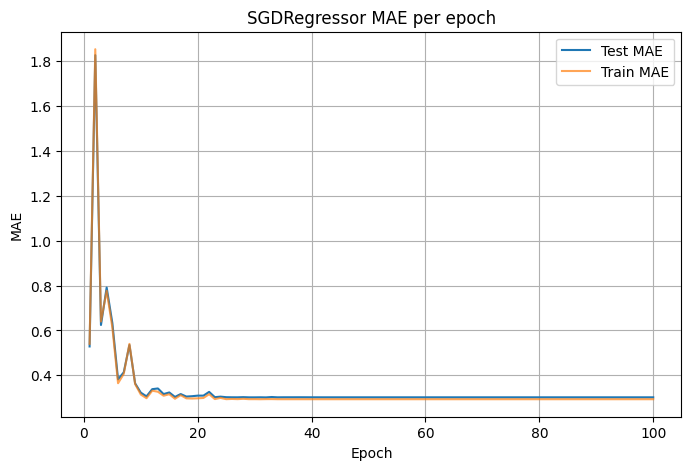

0.2938042083720052


In [144]:
# Define pipeline steps 
full_pipeline = get_preprocessed_pipeline(visual_train_data, "None")
preproc = full_pipeline.named_steps['preprocessing']
pca = full_pipeline.named_steps['pca']

# Fit preprocessors on training data
preproc = preproc.fit(visual_train_data)
visual_train_data_prep = preproc.transform(visual_train_data)

# Fit PCA on preprocessed training data 
pca = pca.fit(visual_train_data_prep)
visual_train_data_feat = pca.transform(visual_train_data_prep)

# transform test features once
visual_test_data_feat = pca.transform(preproc.transform(visual_test_data))

epochs = 100
test_mae_per_epoch = []
train_mae_per_epoch = []

for epoch in range(1, epochs + 1):
    # Deterministically fit new regressor with best parameters from gridserach, for 'epoch' iterations
    best_SGD_model = SGDRegressor(**model.best_params_, max_iter=epoch)
    best_SGD_model.fit(visual_train_data_feat, visual_train_labels)

    # Track train MAE
    y_pred_train = best_SGD_model.predict(visual_train_data_feat)
    train_MAE = MAE(y_pred_train, visual_train_labels)
    train_mae_per_epoch.append(train_MAE)
    # Track test MAE
    y_pred_test = best_SGD_model.predict(visual_test_data_feat)
    test_mae = MAE(y_pred_test, visual_test_labels)
    test_mae_per_epoch.append(test_mae)


# Plot MAE vs epoch
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), test_mae_per_epoch, label='Test MAE')
plt.plot(range(1, epochs+1), train_mae_per_epoch, label='Train MAE', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('SGDRegressor MAE per epoch')
plt.legend()
plt.grid(True)
plt.show()

print(min(train_mae_per_epoch))

In [142]:
def KN_Gridsearch(X_train, y_train):
    import warnings
    warnings.filterwarnings('ignore')
    
    # n_neighbors: number of neighbors to consider
    # p: power parameter for the Minkowski metric

    params = {
        "n_neighbors": [i for i in range(1, 30)],
        "weights": [ 'uniform', 'distance' ],
        "leaf_size": [10, 20, 30, 40, 50],
        "p": [1,2,3,5,10]
    }
    model = GridSearchCV( KNeighborsRegressor(), params, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1 )

    _, mean_absolute_error = train_model_pipeline( get_preprocessed_pipeline, model, X_train, y_train )
    return mean_absolute_error, model

mean_absolute_error_kn, model = KN_Gridsearch(X, y)
print("MAE: ", mean_absolute_error_kn)
print("Optimal params: ", model.best_params_) 
print("Best score: ", model.best_score_)   

### Autograder 

In the autograder you will need to provide two things: 1) estimate of the MAE of your model on unseen data, 2) the predictions on the autograder data. For the autograder data we only provide the features and not the regression targets. Thus, you cannot compute the MAE on this data yourself - you need to estimate that with the data provided above. 

In [ ]:
data_autograder = pd.read_csv('football_autograde.csv')
data_autograder.head()


(14178, 28)

In [ ]:
# TODO Replace this with your own estimate of the MAE of your best model
estimate_MAE_on_new_data = np.array([mean_absolute_error_sgd])

# TODO Replace this with the predictions of your best model
# via e.g. prediction = model.predict(data_autograder)
# your predictions here should again be the $log_{10}(wage)$ of the football player, just as in the provided data. 
predictions_autograder_data = SGD_pipeline.predict( data_autograder )

# Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("autograder_submission.txt", index=False, header=False)

(14178, 158)
